In [9]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_test
import seis_invert
import seis_prior
import seis_nn
import cupy as cp
import seis_diagnostics
import seis_forward
import seis_forward2
import seis_model

In [2]:
#data2=kgs.load_all_test_data()+
data2=kgs.load_all_train_data()

In [3]:
df = kgs.dill_load(kgs.temp_dir + '/style_B_df.pickle')
tr = df['is_train']
ntr = np.logical_not(df['is_train'])
df2 = df[tr].sort_values('seis_err_rms', ascending=True)
print(df2)
data = []
for cn in df2['cache_name'][:50]:
    for d in data2:
        if d.cache_name() == cn:
            #print(cn)
            data.append(d)
model = seis_model.default_model()
model.models[1].run_in_parallel = False

              cache_name  is_train  update_mae  score_brendan      score  \
72   data1__Style_B__144      True   24.021914      28.843061  20.272838   
135  data1__Style_B__270      True   31.830748      35.045888  20.286637   
245  data1__Style_B__490      True   28.677122      35.096020  24.747772   
193  data1__Style_B__386      True   36.705993      42.089632  25.856482   
120  data1__Style_B__240      True   26.599199      33.852749  24.200757   
..                   ...       ...         ...            ...        ...   
8     data1__Style_B__16      True   40.336740      56.171914  40.324762   
187  data1__Style_B__374      True   38.301720      48.964153  33.972459   
216  data1__Style_B__432      True   43.456679      58.968321  40.964142   
157  data1__Style_B__314      True   60.459100      71.931102  44.918423   
188  data1__Style_B__376      True   55.078311      62.328757  37.194834   

               seis_err_rms  seis_err_rms_brendan  
72    1.839473273411593e-05  0.0148

In [12]:
d=data[0]

d_inferred = seis_nn.default_pretrained.infer([d])[0]
d.load_to_memory()
vel_true = d.velocity
vel_est = d_inferred.velocity_guess
vel_est.to_cupy()

scales = np.linspace(0.,1.,21)
mat_list_vel = [] # velocities
mat_list_seis = []
for s in scales:
    vel_intermediate = copy.deepcopy(vel_true)
    vel_intermediate.from_vector(s*vel_true.to_vector() + (1-s)*vel_est.to_vector())
    mat_list_vel.append(cp.asnumpy(vel_intermediate.data))

    seis_intermediate = copy.deepcopy(d.seismogram)
    seis_intermediate.from_vector(seis_forward2.vel_to_seis(vel_intermediate.to_vector())[0])
    mat_list_seis.append(cp.asnumpy(seis_intermediate.data[2,...]))
mat_vel = np.stack(mat_list_vel)
mat_seis = np.stack(mat_list_seis)
d.unload()

In [13]:
importlib.reload(seis_diagnostics)
seis_diagnostics.animate_3d_matrix(mat_vel, title='Velocity', cmap='viridis');

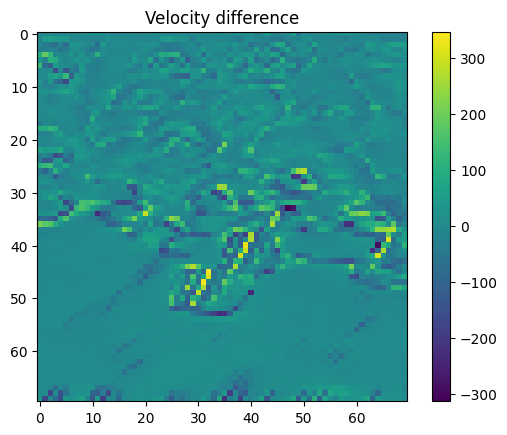

In [14]:
plt.figure();plt.imshow(mat_vel[0,...]-mat_vel[-1,...], cmap='viridis');plt.colorbar();plt.title('Velocity difference');

In [15]:
importlib.reload(seis_diagnostics)
seis_diagnostics.animate_3d_matrix(mat_seis-mat_seis[-1,...], title='Seismogram minus end', cmap='bone');

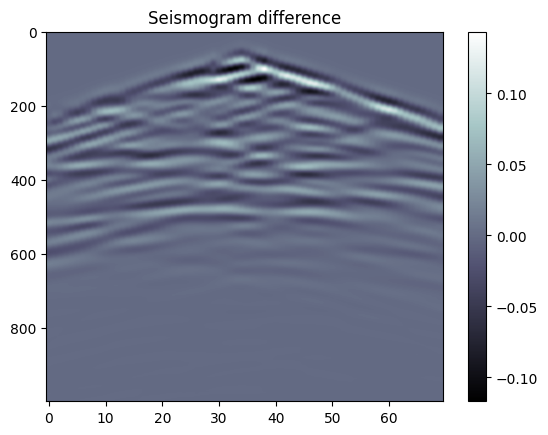

In [16]:
plt.figure();plt.imshow(mat_seis[0,...]-mat_seis[-1,...], cmap='bone', aspect='auto');plt.colorbar();plt.title('Seismogram difference');